# 01 - Yielding and Generators

## Overview

We're going to be looking at:
- **generators** which is a type of iterator
- **generator functions** which is a **generator factory** (they return a generator when called, but they are not generators themselves).
- **generator expressions** which uses the comprehension syntax to concisely create generators. They're useful for simple situations.
- **performance considerations** of generators vs lists.

#### Lecture

We saw in the last section how we could make a factorial iterator which could be iterated through, but a large amount of code was needed. 

What if we could do something like:

```python
def factorials(n):
    for i in range(n):
        <emit> factorial(i)
        <pause> execution here
        wait for <resume>
    return 'done!'

facts = factorials(4)
get_next(facts)
get_next(facts)
```

Where, calling the `factorials(4)` function doesn't do any iteration - it just creates some object. `get_next` is some function that just retrieves the next thing emitted from `factorials`.

When `get_next` is called for the second time, we want our `factorials` to be told that it can now `<resume>` and go to the top of the loop again.

An essential feature that we need for this is to **emit** things out of functions without returning, because returning exits the function. We want it to retain its state (scope values etc) and be able to jump in and out of the function as we please.

The functionality of **emit**, **pause** and **resume** is all handled by the keyword `yield` in python.

**Yield**

1. It emits a value, suspending the function but retaining its current state).
2. Calling `next` on the function **resumes** running the function right after the yield statement.
3. If function **returns** something instead of yielding, then `yield` knows the function has finished running and will raise `StopIteration` exception.

Let's walk through a simple example.

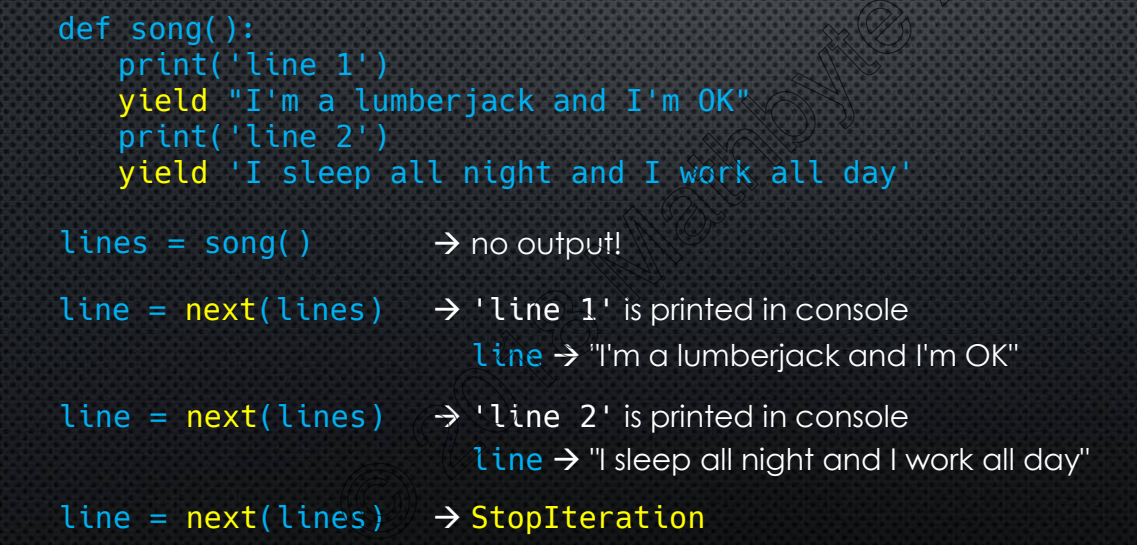

It's very important to recognise that when the function `song()` is called, nothing happens at all, not even the first print statement! This is because python detected a yield statement in the function.

Once we call `next`, we resume the function, executing the `yield` and storing it in a variable.

**Generator Function / Generator Factories**

A generator function is a function that uses the `yield` statement, just like `song()` above. Calling a **generator function** returns a **generator object**. You can think of Python packaging up everything inside the **generator function** into a single object.

**Generators**

Once we've called our generator function and got a generator back, we can now call `next()` on the generator. This is because **generators implement the iterator protocol**.

**`StopIteration`**

As mentioned above, once we reach the return statement of the generator function, we raise `StopIteration`. But, **the exception message is the return value**.

**Iterator vs Generator Comparsion**

Let's write out the factorial function using an iterator and a generator and we'll see how significantly they differ.

In [5]:
import math

class FactIter:
    def __init__(self, n):
        self.n = n
        self.i = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.i >= self.n:
            raise StopIteration

        else: 
            result = math.factorial(self.i)
            self.i += 1
            return result

fact_iter = FactIter(5)

In [8]:
import math

def factorials(n):
    for i in range(n):
        yield math.factorial(i)

fact_iter = factorials(5)

#### Coding

Taking a look at that last example again:

In [1]:
import math

def factorials(n):
    for i in range(n):
        yield math.factorial(i)

fact_iter = factorials(5)

Notice that `factorials` is a function (technically, a generator function/factory), while `fact_iter` is a generator. In other words, calling a generator function/factory produces a generator object. 

And recall that **generators are a type of iterator**.

In [12]:
print(f'{type(factorials)=}')
print(f'{type(fact_iter)=} \n')

print(f"{'__iter__' in dir(fact_iter)=}")
print(f"{'__next__' in dir(fact_iter)=}")
print(f"{iter(fact_iter) is fact_iter=}")

type(factorials)=<class 'function'>
type(fact_iter)=<class 'generator'> 

'__iter__' in dir(fact_iter)=True
'__next__' in dir(fact_iter)=True
iter(fact_iter) is fact_iter=True


# 02 - Example - Fibonacci Sequence

We can implement a fibonacci sequence function in several ways, but we've commonly seen 4: **Recursive (with memoisation)**, **non-recursive**, **iterator** and **closure**. We'll quickly show those four approaches:

#### Recursive

This is still problematic regarding recursion depth even with memoisation.

In [35]:
from functools import lru_cache

@lru_cache()
def fib_recursive(n):
    if n <= 1:
        return 1
    else:
        return fib_recursive(n-1) + fib_recursive(n-2)

In [36]:
fib_recursive(10)

89

#### Non-recursive

Not a particularly bad approach.

In [40]:
def fib(n):
    fib_0 = 1
    fib_1 = 1
    for i in range(n-1):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
    return fib_1

In [41]:
fib(10)

89

#### Iterator Approach

This will utilise the non-recursive function but while enabling us to perform lazy evaluation. It's problematic because every time the `for` loop calls `__next__`, it has to calculate all the fibonacci values internally because it uses the `fib()` function. 

In [46]:
def fib_standard(n):
    fib_0 = 1
    fib_1 = 1
    for i in range(n-1):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
    return fib_1

class FibIter:
    def __init__(self, n):
        self.n = n
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.i >= self.n:
            raise StopIteration

        else:
            result = fib(self.i)
            self.i += 1
            return result

In [47]:
fib_iter = FibIter(7)

for i in fib_iter:
    print(i)

1
1
2
3
5
8
13


#### Closure

The syntax for this implementation is a little convoluted and not very clear.

Just like the iterator approach above, it's problematic because every time the `for` loop calls `__next__`, it has to calculate all the fibonacci values internally because it uses the `fib()` function - that is wasteful..

In [65]:
def fib_standard(n):
    fib_0 = 1
    fib_1 = 1
    for i in range(n-1):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
    return fib_1

def fib_closure():
    i = 0
    def inner():
        nonlocal i
        result = fib_standard(i)
        i += 1
        return result
    return inner

In [66]:
my_fib = fib_closure()

for i in range(7):
    print(my_fib())

1
1
2
3
5
8
13


Alternatively, we could just produce an iterator from the closure and set up a sentinel value of whatever `fib(7)` is.

**Quick reminder: Second form of the `iter()` function**:

In the first form, we saw that `iter()` returns an iterator which leverages either the `__iter__` method (if iterator protocol implemented) or `__getitem__` (if sequence protocol implemented). 

In the second form, we can also let it control termination with the sentinel value -> **`iter(callable, sentinel)`**. This doesn't require the first argument to have implemented `__iter__` or `__getitem__`; it just needs to return a value every time it's called, i.e. a callable.

This will return an **iterator** that will:
- call the callable when `next()` is called.
- either
  - raise `StopIteration`if the result is equal to the **sentinel** value.
  - return the result otherwise.

In [55]:
def fib(n):
    fib_0 = 1
    fib_1 = 1
    for i in range(n-1):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
    return fib_1

def fib_closure():
    i = 0
    def inner():
        nonlocal i
        result = fib(i)
        i += 1
        return result
    return inner

my_fib = fib_closure()

fib_iter = iter(my_fib, fib(7))

for i in fib_iter:
    print(i)

1
1
2
3
5
8
13


#### Generator 

This approach is arguable the best one because it performs lazy evaluation like iterators but it doesn't need to recalculate previous values every time it wants to calculate the next value. 

Also, it is *extremely* fast which we'll prove below.

In [67]:
def fib(n):
    fib_0 = 1
    yield fib_0
    fib_1 = 1
    yield fib_1
    
    for i in range(n-2):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
        yield fib_1

In [68]:
gen = fib(7)
for i in gen:
    print(i)

1
1
2
3
5
8
13


To show how fast it is, we will compare it to the **non-recursive approach that utilises `FibIter` for lazy evaluation**.

In [70]:
def fib_standard(n):
    fib_0 = 1
    fib_1 = 1
    for i in range(n-1):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
    return fib_1

In [71]:
def fib_gen(n):
    fib_0 = 1
    yield fib_0
    fib_1 = 1
    yield fib_1
    
    for i in range(n-2):
        fib_0, fib_1 = fib_1, fib_0 + fib_1
        yield fib_1

In [77]:
class FibIter:
    def __init__(self, n):
        self.n = n
        self.i = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.i >= self.n:
            raise StopIteration

        else:
            result = fib_standard(self.i)
            self.i += 1
            return result

**Non-recursive speed**

In [80]:
from timeit import timeit
timeit('[num for num in FibIter(5_000)]', globals=globals(), number=1)

0.8088771998882294

**Generator speed**

In [81]:
timeit('[num for num in fib_gen(5_000)]', globals=globals(), number=1)

0.0006814002990722656

# 03 - Making an Iterable from a Generator

#### Generators used with other Generators

I want to point out that you can also easily run into various bugs when you use generators with other generator functions.

Consider this example:

In [31]:
def squares(n):
    for i in range(n):
        yield i ** 2

sq = squares(5)

`squares(5)` is a generator function so `sq` is a generator object. What if we place this generator as an argument into another **iterator** such as `enumerate`?

In [32]:
enum_sq = enumerate(sq)

At this point, `enum_sq` has done nothing to `sq` because it `enumerate` uses **lazy evaluation**; it will only `yield` from `sq` when asked to do so. 

To walk through `enumerate`'s process, it will:
1. Start up an index counter at index 0
2. Yield from `sq` using `next`.
3. Store the index and the yielded value in a tuple `(<index>, <yielded_value>)`
4. Incrmment index and carry on from step 2.

Let's manually `yield` `sq` ourselves.

In [33]:
print(next(sq))
print(next(sq))

0
1


Now if we call `list(enum_sq)`, it will appear 'out-of-sync` because `enumerate` will just `yield` from wherever we left off.

In [34]:
list(enum_sq)

[(0, 4), (1, 9), (2, 16)]

#### Making an iterable


So how do we make an iterable to save us the hassle of creating a new iterator every time we exhaust our first iterator?

**The solution is to make a class that implements the `iterable protocol`. In other words, in the `__iter__` method, it must return a new *iterator* not *itself*. We've done this many times before - the only difference is the iterator will be a generator.

In [35]:
class Squares:
    def __init__(self, n):
        self.n = n

    def __iter__(self):
        return Squares.squares_gen(self.n)

    @staticmethod
    def squares_gen(n):
        for i in range(n):
            yield i**2

In [36]:
sq = Squares(5)

print(list(sq))
print(list(sq))

[0, 1, 4, 9, 16]
[0, 1, 4, 9, 16]


`sq` is an **iterable** not an **iterator**.

Also, `squares_gen` is a static method because it doesn't require any of the properties of the class - it could have just as easily be written outside of the class.

Note on `@staticmethod`: It can be called from *inside* or *outside* the class with `ClassName.MethodName()` and also using `object.MethodName()`.

# 04 - Example - Card Deck

Let's go back to a previous example we worked with, our card deck.

Let's rebuild it quickly, but this time using generators instead of a custom iterator:

A few notes:
- In `__iter__`, we have to call `card_gen` with `card_gen()` because that returns a generator as opposed to a generator factory.
- In the `reversed_card_gen()` method, we can use `reversed()` on the tuples because they support that protocol.
- `deck` is an **iterable** not an **iterator** because it returns a new iterator (generator in this case) each time.

In [41]:
class CardDeck:
    SUITS = ('Spades', 'Hearts', 'Diamonds', 'Clubs')
    RANKS = tuple(range(2, 11)) + tuple('JQKA')
        
    def __iter__(self):
        return CardDeck.card_gen()
    
    def __reversed__(self):
        return CardDeck.reversed_card_gen() 
    
    @staticmethod
    def card_gen():
        for suit in CardDeck.SUITS:
            for rank in CardDeck.RANKS:
                card = Card(rank, suit)
                yield card
        
    @staticmethod
    def reversed_card_gen():
        for suit in reversed(CardDeck.SUITS):
            for rank in reversed(CardDeck.RANKS):
                card = Card(rank, suit)
                yield card

In [42]:
sentinel = Card(rank=5, suit='Spades')

deck = CardDeck()

for card in deck:
    if card == sentinel:
        break
    else:
        print(card)

Card(rank=2, suit='Spades')
Card(rank=3, suit='Spades')
Card(rank=4, suit='Spades')


In [43]:
sentinel = Card(rank=10, suit='Clubs')

for card in reversed(deck):
    if card == sentinel:
        break
    else:
        print(card)

Card(rank='A', suit='Clubs')
Card(rank='K', suit='Clubs')
Card(rank='Q', suit='Clubs')
Card(rank='J', suit='Clubs')


# 05 - Generator Expressions

Generator expressions/comprehensions are very similiar to list comprehensions - we can have multiple nested loops and/or nested comprehensions inside both of them. 

There are a few key differences. In a generator comprehension:

- we use `()` instead of `[]`
- a generator is returned instead of a list
- evaluation is lazy instead of eager
- returns an (exhaustible) iterator as opposed to an (inexhaustible) iterable

Some notable consequences of the above is that for a generator comprehension:

- it takes less time to be created than a list comprehension
- iteration is slower than a list comprehension as the objects need to be created/calculated at every request.
- **only a single item is loaded into memory as opposed to the entire collection when using a list comprehension.**

Here are some basic examples:

In [44]:
g = (i**2 for i in range(5))
type(g)

generator

In [45]:
for item in g:
    print(item)

0
1
4
9
16


It is now exhausted, we can't iterate through it again.

In [50]:
for item in g:
    print(item)

To prove a function is being created in the background, just like with list comprehensions, we can compile and disassemble the code:

In [51]:
import dis

exp = compile('(i**2 for i in range(5))', filename='<string>', mode='eval')

In [52]:
dis.dis(exp)

  1           0 LOAD_CONST               0 (<code object <genexpr> at 0x0000027F5200C500, file "<string>", line 1>)
              2 LOAD_CONST               1 ('<genexpr>')
              4 MAKE_FUNCTION            0
              6 LOAD_NAME                0 (range)
              8 LOAD_CONST               2 (5)
             10 CALL_FUNCTION            1
             12 GET_ITER
             14 CALL_FUNCTION            1
             16 RETURN_VALUE

Disassembly of <code object <genexpr> at 0x0000027F5200C500, file "<string>", line 1>:
  1           0 LOAD_FAST                0 (.0)
        >>    2 FOR_ITER                14 (to 18)
              4 STORE_FAST               1 (i)
              6 LOAD_FAST                1 (i)
              8 LOAD_CONST               0 (2)
             10 BINARY_POWER
             12 YIELD_VALUE
             14 POP_TOP
             16 JUMP_ABSOLUTE            2
        >>   18 LOAD_CONST               1 (None)
             20 RETURN_VALUE


We can clearly see the `MAKE_FUNCTION` and `CALL_FUNCTION`.

In [54]:
' x '.join('123')

'1 x 2 x 3'

##### Example - Pascal's Triangle

Let's try Pascal's triangle again:

```
1
1 1
1 2 1
1 3 3 1
1 4 6 4 1
```

we just need to know how to calculate combinations:
```
C(n, k) = n! / (k! (n-k)!)
```

* row 0, column 0: n=0, k=0: c(0, 0) = 0! / 0! 0! = 1/1 = 1
* row 4, column 2: n=4, k=2: c(4, 2) = 4! / 2! 2! = 4x3x2 / 2x2 = 6

In other words, we need to calculate the following list of lists:
```
c(0,0)
c(1,0) c(1,1)
c(2,0) c(2,1) c(2,2)
c(3,0) c(3,1) c(3,2) c(3,3)
...
```

Here's how we did it using a list comprehension:

In [66]:
from math import factorial

def combo(n, k):
    return factorial(n) // (factorial(k) * factorial(n-k))

size = 10  # global variable
pascal = [ [combo(n, k) for k in range(n+1)] for n in range(size+1) ]

In [67]:
pascal

[[1],
 [1, 1],
 [1, 2, 1],
 [1, 3, 3, 1],
 [1, 4, 6, 4, 1],
 [1, 5, 10, 10, 5, 1],
 [1, 6, 15, 20, 15, 6, 1],
 [1, 7, 21, 35, 35, 21, 7, 1],
 [1, 8, 28, 56, 70, 56, 28, 8, 1],
 [1, 9, 36, 84, 126, 126, 84, 36, 9, 1],
 [1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1]]

We can now use generator expressions for either one or both of the nested list comprehensions. In this case I'll use it for both:

In [68]:
size = 10  # global variable
pascal = ( (combo(n, k) for k in range(n+1)) for n in range(size+1) )

Iterating through `pascal` will iterate through the outer generator expression, providing us with the inner generator expression:

In [69]:
[row for row in pascal]

[<generator object <genexpr>.<genexpr> at 0x0000027F52018430>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51F7ABA0>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51F7AC80>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEA430>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEA580>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEABA0>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEAF90>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEAE40>,
 <generator object <genexpr>.<genexpr> at 0x0000027F51EEA270>,
 <generator object <genexpr>.<genexpr> at 0x0000027F520219E0>,
 <generator object <genexpr>.<genexpr> at 0x0000027F52021970>]

So, we need to yield all values from each generator expression, using `list()` for example. Remember `pascal` is now exhausted; we need to create it again.

In [70]:
size = 10  # global variable
pascal = ( (combo(n, k) for k in range(n+1)) for n in range(size+1) )

[list(row) for row in pascal]

[[1],
 [1, 1],
 [1, 2, 1],
 [1, 3, 3, 1],
 [1, 4, 6, 4, 1],
 [1, 5, 10, 10, 5, 1],
 [1, 6, 15, 20, 15, 6, 1],
 [1, 7, 21, 35, 35, 21, 7, 1],
 [1, 8, 28, 56, 70, 56, 28, 8, 1],
 [1, 9, 36, 84, 126, 126, 84, 36, 9, 1],
 [1, 10, 45, 120, 210, 252, 210, 120, 45, 10, 1]]

A good thing to remember is the following form:
```python
(<expression_to_yield> for item in <some_iterable>),
```
where the `<expression_to_yield>` is not run until you iterate through the generator expression.

So, if you have a list comprehension inside a generator expression, for example:
```python
([combo(n, k) for k in range(n+1)] for n in range(size+1)), 
```

```python
[combo(n, k) for k in range(n+1)]
```
is the `<expression_to_yield>`, which means that the list comprehension is **not** run until you iterate through the generator expression.

It's important to note that if you must iterate through an entire collection, using a [list comprehension] vs [using a generator expression and iterating through **all** of it] take roughly the same amount of time. 

**So generator expressions are only useful if you're short on memory or if you're iterating through a portion of the collection or you need lazy evaluation.**

# 06 - Yield From

Say we have three files: 'file1.csv', 'file2.csv' and 'file3.csv', and we want to read all lines from the first sequentially using `yield`, then move onto the second, and finally the third. We could write:
```python
def read_all_data():
    for file in ('file1.csv', 'file2.csv', 'file3.csv'):
        with open(file) as f:
            for line in f:
                yield line
```

But you may have noticed that `open()` is an iterator, and therefore(?) supports `yield`, so we can **delegate yielding to `open()`, an iterator.**

```python
def read_all_data():
    for file in ('file1.csv', 'file2.csv', 'file3.csv'):
        with open(file) as f:
            yield from f
```

#### Example 1 - Matrix

Let's look at a function that will create a fairly simple `matrix` and a `matrix_iterator` which will iterate through the matrix to retrieve the values.

In [29]:
def matrix(n):
    gen = ((i * j for j in range(1, n+1)) for i in range(1, n+1))
    return gen

def matrix_iterator(n):
    for row in matrix(n):
        for item in row:
            yield item

`matrix_iterator` contains a `yield` statement so calling it returns a generator object. We must iterate through that generator object to get out the values.

In [30]:
for item in matrix_iterator(3):
    print(item)

1
2
3
2
4
6
3
6
9


But the level of nesting seen in `matrix_iterator` is not great - we can use `yield from` to reduce it slightly. 

Since each `row` in `matrix(n)` is a generator object, and hence an iterator, we can `yield from` it, as opposed to iterating through the (iterator) object and yielding in each iteration.

In [31]:
def matrix_iterator(n):
    for row in matrix(n):
        yield from row

for item in matrix_iterator(3):
    print(item)

1
2
3
2
4
6
3
6
9


Alternatively, we could just iterate through the `matrix_iterator(n)` generator object in one shot using `list`.

In [32]:
list(matrix_iterator(3))

[1, 2, 3, 2, 4, 6, 3, 6, 9]

#### Example 2 - Car brands

For this example, we have 3 files all containing a list of car names. We want to iterate through each of these files sequentially and print out each one. 

Here's how we'd do it:

In [56]:
root = "../Section 06 - Generators/06 - Yield From/"

file_names = 'car-brands-1.txt', 'car-brands-2.txt', 'car-brands-3.txt'
files = [root + file for file in file_names]


def gen_clean_read(file):
    with open(file) as f:
        for line in f:
            yield line.strip('\n')

def brands(*files):
    for file in files:
        yield from gen_clean_read(file)
        
for brand in brands(*files):
    print(brand, end=', ')

Farboud, Ferrari, Fiat, Ford, Honda, Hummer, Hyundai, Jaguar, Jeep, KIA, Koenigsegg, Lada, Lamborghini, Lancia, Land Rover, Lexus, Ligier, Lincoln, Lotus, Martini, Maserati, Maybach, Mazda, McLaren, Mercedes-Benz, Mini, Mitsubishi, Nissan, Noble, Opel, Peugeot, Pontiac, Porsche, Renault, Rolls-Royce, Saab, Seat, Å koda, Smart, Spyker, Subaru, Suzuki, Toyota, Vauxhall, Volkswagen, Volvo, 

Since we are using `yield from`, we will need a `gen_clean_read` file